# Forward diff simple example (1D-PDE)

The one-dimensional diffusion equation is:

$$\frac{\partial u}{\partial t}= \nu \frac{\partial^2 u}{\partial x^2}$$

## Loading libraries

In [74]:
using Plots, DifferentialEquations, DiffEqOperators

## Setting up the problem

**Spatial discretisation**

In [75]:
nx = 101; # number of discretised points xi
l=2.0;    # Domain length
Δx = l / (nx - 1);
x = 0:Δx:l

0.0:0.02:2.0

**Diffusion coefficient**

In [76]:
ν = 40.0;

**Defining the difference equation** (method of lines)


$$\frac{\partial u(x,t)}{\partial t}= \nu \cfrac{u(x+\Delta x,t) - 2 u(x,t) + u(x-\Delta x,t)}{\Delta x^2}$$

In [77]:
A = DerivativeOperator{Float64}(2,2,Δx,nx,:Neumann,:Neumann;BC=(0.,0.));
A_array = convert(Array,A)

101×101 Array{Float64,2}:
 -8750.0  10000.0   -1250.0      0.0  …      0.0       0.0      0.0      0.0
     0.0   5000.0  -12500.0  10000.0         0.0       0.0      0.0      0.0
     0.0   2500.0   -5000.0   2500.0         0.0       0.0      0.0      0.0
     0.0      0.0    2500.0  -5000.0         0.0       0.0      0.0      0.0
     0.0      0.0       0.0   2500.0         0.0       0.0      0.0      0.0
     0.0      0.0       0.0      0.0  …      0.0       0.0      0.0      0.0
     0.0      0.0       0.0      0.0         0.0       0.0      0.0      0.0
     0.0      0.0       0.0      0.0         0.0       0.0      0.0      0.0
     0.0      0.0       0.0      0.0         0.0       0.0      0.0      0.0
     0.0      0.0       0.0      0.0         0.0       0.0      0.0      0.0
     0.0      0.0       0.0      0.0  …      0.0       0.0      0.0      0.0
     0.0      0.0       0.0      0.0         0.0       0.0      0.0      0.0
     0.0      0.0       0.0      0.0         0.0  

In [78]:
dudt(u,p,t) = p[1].*A_array*u;

**Defining the ODE-solvers**

In [79]:
"""
diffusion solve the diffusion equation

Parameters
----
p: diffusion coefficient

Returns
----
sol1: solution of the PDE at the simulates timesteps
"""
function diffusion(p)
    prob1 = DifferentialEquations.ODEProblem(dudt,eltype(p).(u0),eltype(p).((0.0,time_end)),p);
    sol1 = DifferentialEquations.solve(prob1,DifferentialEquations.Rodas5(),saveat=1e-5);
    return sol1
end

diffusion

**Initial condition**

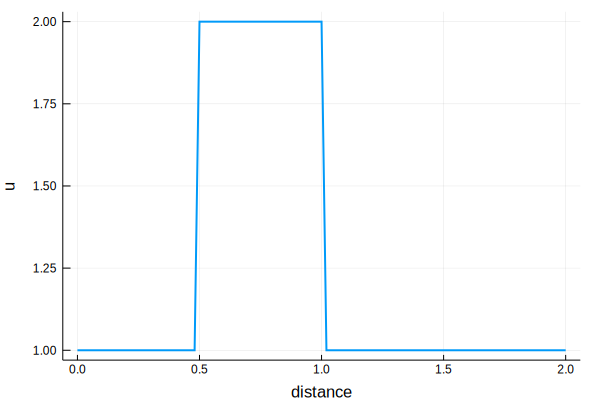

In [80]:
u0 = [0.5 ≤ xi ≤ 1.0 ? 2.0 : 1.0 for xi in x];
plot(x,u0,
     xlabel="distance",ylabel="u",label="",lw=2)

**Simulation**

In [81]:
time_end = 0.5e-2;
solution = diffusion(ν);

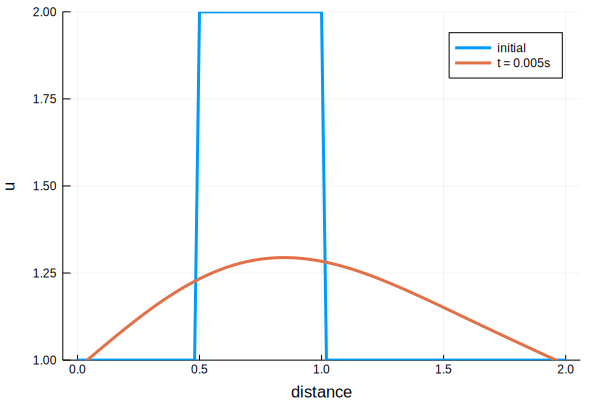

In [82]:
for i=1:500
   IJulia.clear_output(true)
   plot(x,u0,xlabel="distance",ylabel="u",label=["initial"],ylim=(1,2),lw=3)
   plot!(x,solution.u[i],xlabel="distance",ylabel="u",label = "t = $(round(i*1e-5,digits=4))s",ylim=(1,2),lw=3) |> display
   sleep(0.01)
end 

## Effect of diffusion coefficient (ν)

Let's plot for a for a few values of $\nu$

In [83]:
"""
diffusion solve the diffusion equation

Parameters
----
p: diffusion coefficient

Returns
----
sol1: solution of the PDE at the final timestep
"""

function diffusion(p)
    prob1 = DifferentialEquations.ODEProblem(dudt,eltype(p).(u0),eltype(p).((0.0,time_end)),p);
    sol1 = DifferentialEquations.solve(prob1,DifferentialEquations.Tsit5(),save_everystep=false);
    return sol1[end]
end

diffusion (generic function with 1 method)

In [19]:
time_end = 1e-3;
u = [diffusion(ν) for ν in [1,10.0,100]];

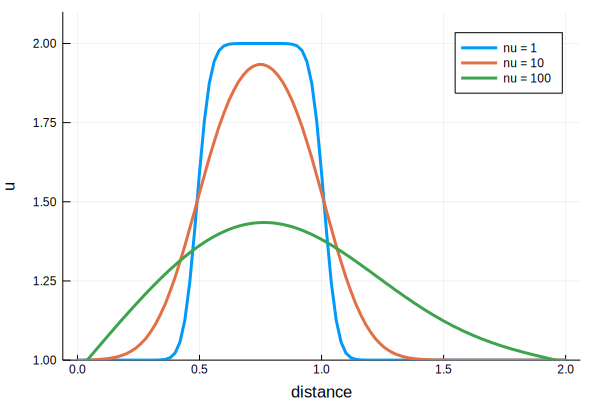

In [84]:
plot(x,u,xlabel="distance",ylabel="u",label=["nu = 1","nu = 10","nu = 100"],ylim=(1,2.1),lw=3)
#savefig("figs/diffusion.svg")

## Parameter estimation

Assuming $\nu = 40.0$ is the true value of the parameter the "exact" solution of the algorithm is,

In [85]:
ν_true = 40.0;
u_true = diffusion(ν_true);

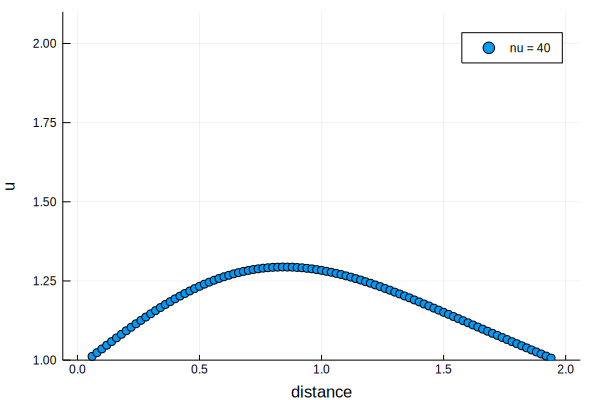

In [86]:
scatter(x,u_true,xlabel="distance",ylabel="u",label=["nu = 40"],ylim=(1,2.1),lw=3)

The L2-norm (SSE) is used as measure for the goodness-of-fit

$${\displaystyle SSE=\sum _{i=1}^{n}(y_{i}-f(x_{i}))^{2}}$$

In [87]:
lossL2(fu,p,u) = sum((u - fu(p)).^2);                                 # L2 loss (SSE)

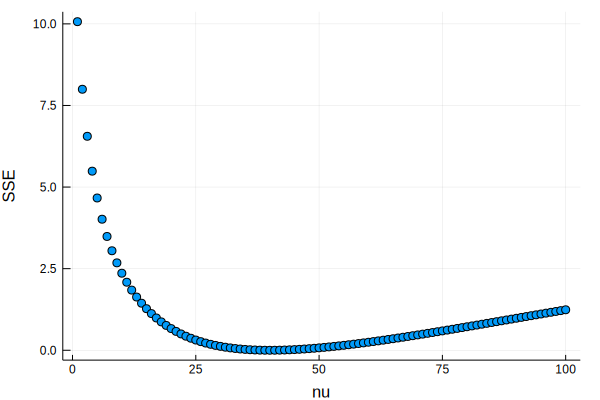

In [88]:
ν = 1:1.0:100;
out = [lossL2(diffusion,νi,u_true) for νi in ν];
scatter(ν,out,xlabel="nu",ylabel="SSE",label="",lw=3)

**Calibration**
Let us find the minimum of the loss function to calibrate or PDE

In [89]:
using Optim, LineSearches, BenchmarkTools, ForwardDiff

Our first guess of ν

In [90]:
ν0 = 10.0;

Using Newton-Raphson optimiser

In [91]:
algo = Newton();

In [92]:
ν_est = optimize(p->lossL2(diffusion,first(p),u_true), [ν0], algo,autodiff= :forward).minimizer

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/bram/.julia/packages/DiffEqBase/EFqMn/src/integrator_interface.jl:150
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase /home/bram/.julia/packages/DiffEqBase/EFqMn/src/integrator_interface.jl:156


1-element Array{Float64,1}:
 40.01244559163714

In [72]:
u_est = diffusion(ν_est);

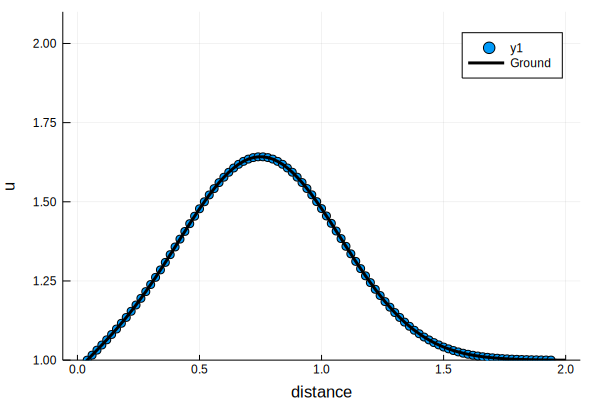

In [73]:
scatter(x,u_true)
plot!(x,u_est,xlabel="distance",ylabel="u",label=["Ground","Estimated PDE"],ylim=(1,2.1),lw=3,color=:black)

*Internal finite differencing:*

In [29]:
b = @benchmarkable optimize(p->lossL2(diffusion,first(p),u_true), [ν0], algo,autodiff= :forward) samples=30 evals=3 seconds=180 time_tolerance=0.01
run(b)

BenchmarkTools.Trial: 
  memory estimate:  2.97 GiB
  allocs estimate:  2015836
  --------------
  minimum time:     950.236 ms (32.51% GC)
  median time:      1.194 s (32.24% GC)
  mean time:        1.379 s (29.13% GC)
  maximum time:     6.419 s (10.93% GC)
  --------------
  samples:          30
  evals/sample:     3

In [30]:
b = @benchmarkable optimize(p->lossL2(diffusion,first(p),u_true), [ν0], algo) samples=30 evals=3 seconds=180 time_tolerance=0.01
run(b)

BenchmarkTools.Trial: 
  memory estimate:  2.47 GiB
  allocs estimate:  4026849
  --------------
  minimum time:     1.500 s (23.73% GC)
  median time:      2.785 s (15.24% GC)
  mean time:        2.905 s (14.84% GC)
  maximum time:     4.305 s (9.56% GC)
  --------------
  samples:          22
  evals/sample:     3